You’re tasked with optimising an ML model by tuning six hyperparameters, for example learning rate, regularisation strength or number of hidden layers. The function you’re maximising is the model’s performance score (such as accuracy or F1), but since the relationship between inputs and output isn’t known, it’s treated as a black-box function. 

Because this is a commonly used model, you might benefit from researching best practices or literature to guide your initial search space. Your goal is to find the combination of hyperparameters that yields the highest possible performance.

In [1]:
import numpy as np
import pandas as pd

In [2]:
inputs_f7 = np.load('function_7/initial_inputs.npy')
outputs_f7 = np.load('function_7/initial_outputs.npy')

In [3]:
print("Inputs (Function 7):", inputs_f7)

Inputs (Function 7): [[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 

In [4]:
print("Outputs (Function 7):", outputs_f7)

Outputs (Function 7): [0.6044327  0.56275307 0.00750324 0.0614243  0.2730468  0.08374657
 1.3649683  0.09264495 0.0178696  0.03356494 0.0735163  0.2063097
 0.00882563 0.26840032 0.61152553 0.01479818 0.27489251 0.06676325
 0.04211835 0.00270147 0.01820907 0.00701603 0.10050661 0.47539552
 0.67514163 0.51645722 0.00377748 0.00313433 0.02134252 0.09541116]


Best value 

In [5]:

idx_best = np.argmax(outputs_f7)
x_best = inputs_f7[idx_best]
y_best = outputs_f7[idx_best]

print("Best hyperparameter combination:", x_best)
print("Best output:", y_best)

Best hyperparameter combination: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Best output: 1.3649683044991994


Visualtize the plots 

Shows 2D projections of hyperparameters

Color = output value

Helps visually identify regions of high output

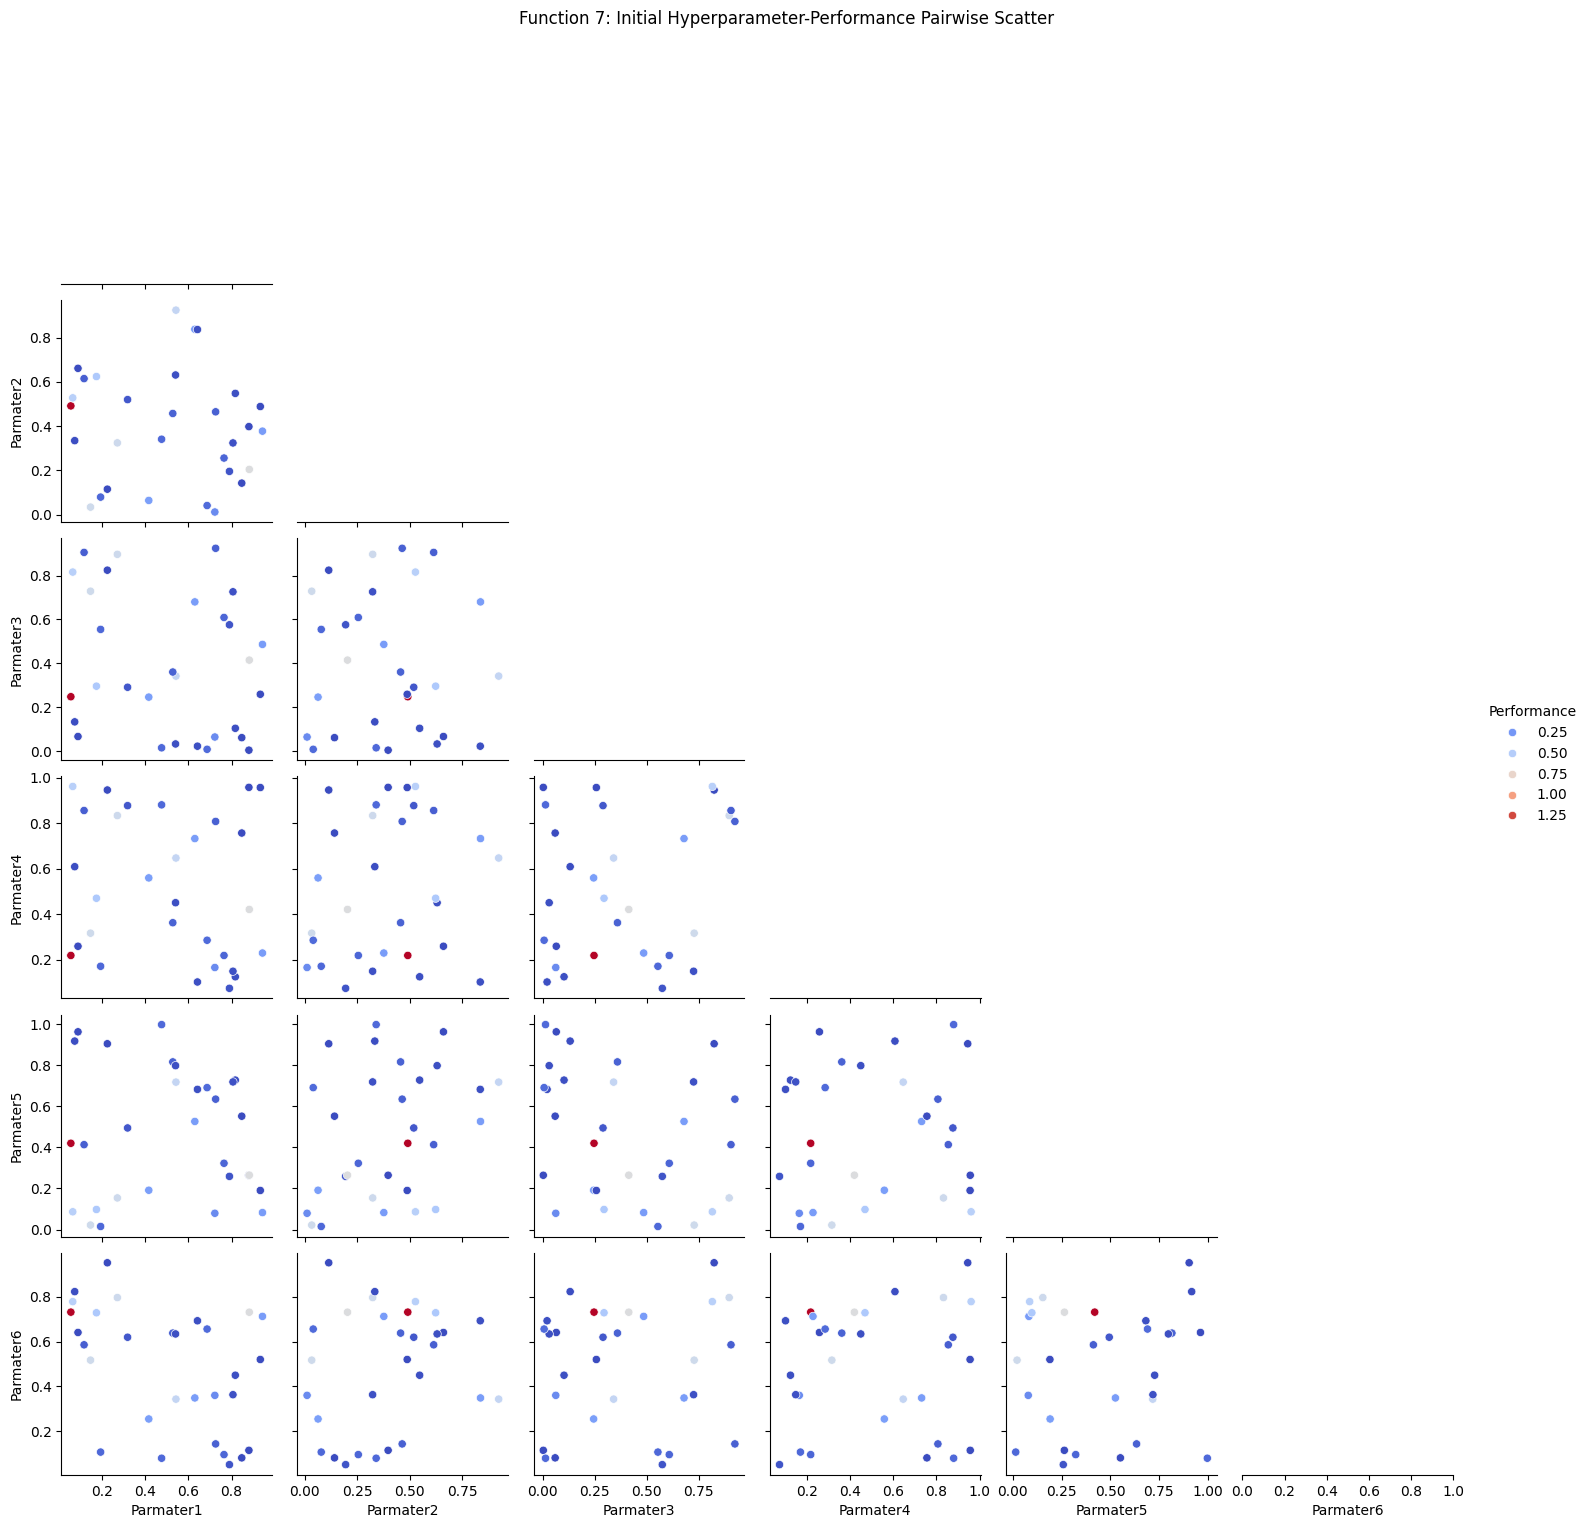

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1b: Pairwise scatter plots (for small number of hyperparams)
df = pd.DataFrame(inputs_f7, columns=[f'Parmater{i+1}' for i in range(6)])
df['Performance'] = outputs_f7
sns.pairplot(df, hue='Performance', palette='coolwarm', corner=True)
plt.suptitle('Function 7: Initial Hyperparameter-Performance Pairwise Scatter', y=1.02)
plt.show()

Fit the gaussian process

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# 2a. Kernel for smooth + noisy outputs
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6,1.0))



In [8]:
gp_f7 = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10, random_state=42)
gp_f7.fit(inputs_f7, outputs_f7)
print("Optimized kernel:", gp_f7.kernel_)

Optimized kernel: 0.995**2 * RBF(length_scale=0.28) + WhiteKernel(noise_level=1e-06)


/opt/homebrew/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Step 3: Suggest the next point using UCB

Goal: maximize output (less negative)

In [9]:
# Step 3: Suggest next point using UCB
num_candidates = 20000  # dense sampling for 6D space
X_candidates = np.random.rand(num_candidates, 6)

mu, sigma = gp_f7.predict(X_candidates, return_std=True)

# Exploration-focused UCB
kappa = 5.0  # higher = more exploration
UCB = mu + kappa * sigma

idx_next = np.argmax(UCB)
x_next = X_candidates[idx_next]

print("Next hyperparameters suggested by BO:", x_next)

Next hyperparameters suggested by BO: [0.06811856 0.24457751 0.21107869 0.09540261 0.33323947 0.73000736]


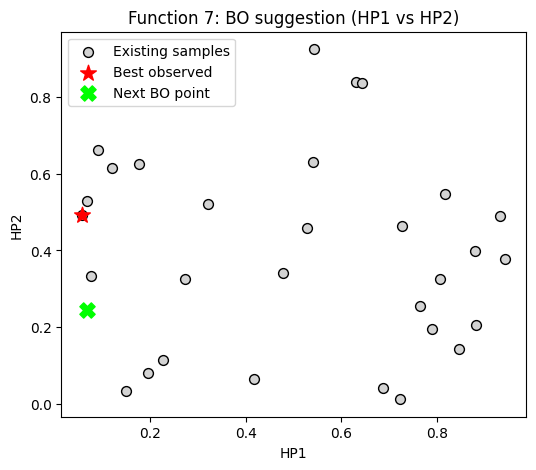

In [10]:
# Example: Flour vs Sugar
plt.figure(figsize=(6,5))
plt.scatter(inputs_f7[:,0], inputs_f7[:,1], c='lightgray', s=50, edgecolors='black', label='Existing samples')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Best observed')
plt.scatter(x_next[0], x_next[1], c='lime', s=120, marker='X', label='Next BO point')
plt.xlabel('HP1')
plt.ylabel('HP2')
plt.title('Function 7: BO suggestion (HP1 vs HP2)')
plt.legend()
plt.show()